In [317]:
# 패키지 불러오기
require(ggplot2)
require(repr)
options(repr.plot.width=10, repr.plot.height=3)

In [308]:
# 삭제
rm(list = ls())

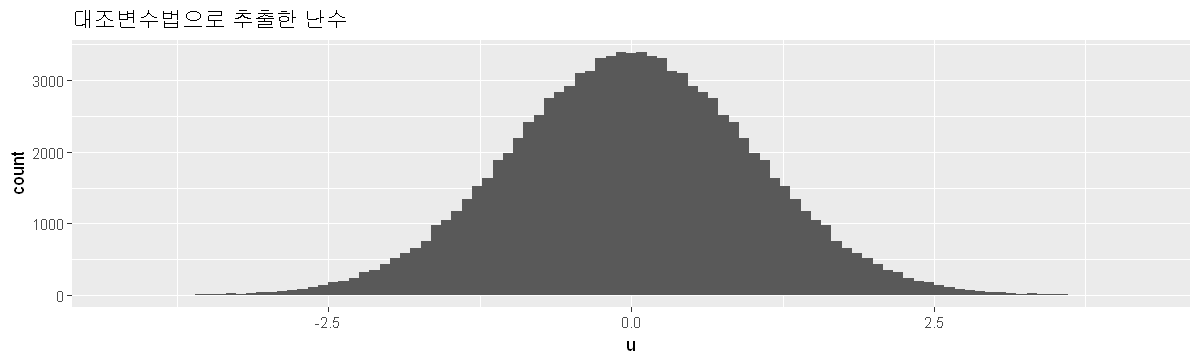

In [309]:
# 대조변수법
Antithetic.rand <- function(scens, vars=1){
    isodd = scens%%2
    num = scens%/%2 + isodd
    z <- matrix(rnorm(num*vars, mean=0, sd=1), num, vars)
    value <- rbind(z,-z)
    if(isodd == TRUE) value <- value[-1,]
    return(scale(value))
}
    
u <- Antithetic.rand(100000)
ggplot() +
    geom_histogram(aes(x=u), bins=100) +
    labs(title='대조변수법으로 추출한 난수')

In [454]:
# Smith-Wilson Class 정의
setClass('Smith.Wilson',
        representation(alpha="numeric", UFR="numeric", terms="numeric", int="numeric", zeta="numeric"))

# Wilson function 메소드 정의
setGeneric("Wilson", function(object, ...) standardGeneric("Wilson"))
setMethod("Wilson", "Smith.Wilson", function(object,t,u){
    y <- exp(object@UFR*(t+u))*(object@alpha*pmin(t,u) - 0.5*exp(-object@alpha*pmax(t,u))*(exp(object@alpha*pmin(t,u)) - exp(-object@alpha*pmin(t,u))))
    return(y)
})
    
# Derivative of Wilson function 메소드 정의
setGeneric("derivWilson", function(object, ...) standardGeneric("derivWilson"))
setMethod("derivWilson", "Smith.Wilson", function(object,t,u){
    if (t>u) {
        y <- -object@UFR*Wilson(object,t,u) + object@alpha*exp(-object@UFR*(t+u)) * (1-exp(-object@alpha*u)*cosh(object@alpha*t)) 
    }
    else {
        y <- -object@UFR*Wilson(object,t,u) + object@alpha*exp(-object@UFR*(t+u)) * exp(-object@alpha*t)*sinh(object@alpha*u)
    }
    return(y)
})
    
# Bond Price 메소드 정의
setGeneric("P", function(object, ...) standardGeneric("P"))
setMethod("P", "Smith.Wilson", function(object,t){
    p <- exp(-object@UFR*t) + object@zeta %*% Wilson(object, t, object@terms)
    return(p)
})    
    
# Derivative of Bond Price 메소드 정의
setGeneric("derivP", function(object, ...) standardGeneric("derivP"))
setMethod("derivP", "Smith.Wilson", function(object,t){
    y<- -object@UFR*exp(-object@UFR*t) + sapply(object@terms, FUN=function(x) derivWilson(object,t,x))%*%object@zeta
    return(y)
})   
    
# 금리 보정 결과 메소드
setGeneric("R", function(object, ...) standardGeneric("R"))
setMethod("R", "Smith.Wilson", function(object, t){
    r <- (1/P(object, t))^(1/t) - 1
    return(r)
})

# 객체 초기화
setMethod("initialize", "Smith.Wilson", function(.Object, alpha, UFR, terms, int){
    .Object@alpha <- alpha
    .Object@UFR <- UFR
    .Object@terms <- terms
    .Object@int <- int
    
    W <- outer(terms, terms, FUN=function(x,y) Wilson(.Object, x, y))
    m  <- 1/(1+int)^terms
    mu <- exp(-UFR*terms)
    .Object@zeta <- as.numeric((m-mu)%*%solve(W))
    
    return(.Object)
})

[1] "Wilson"

[1] "Wilson"

[1] "derivWilson"

[1] "derivWilson"

[1] "P"

[1] "P"

[1] "derivP"

[1] "derivP"

[1] "R"

[1] "R"

[1] "initialize"

In [447]:
# 입력 데이터
int.rate <- c(0.0334,0.0326,0.0327,0.0328,0.033,0.0335,0.0342,0.0345,0.0347,0.0352)
int.mat <- c(1,2,3,4,5,7,10,12,15,20)
vol <- matrix (c(0.1815,0.172,0.17,0.1605,0.158,0.155,
                 0.177,0.1715,0.17,0.158,0.1545,0.15,
                 0.174,0.168,0.1655,0.1555,0.1495,0.1475,
                 0.165,0.1575,0.157,0.1495,0.1455,0.144,
                 0.165,0.1575,0.157,0.1535,0.1455,0.144,
                 0.1665,0.159,0.1575,0.15,0.1455,0.14),
                 ncol=6, byrow=TRUE)
colnames(vol) <- rownames(vol) <- tenor <- c(1,2,3,5,7,10)
N <- 100

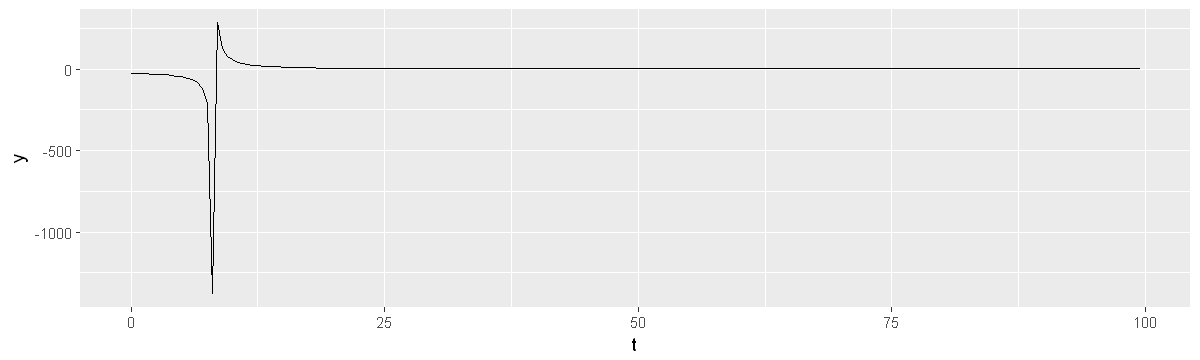

In [475]:
# Smith-Wilson 객체 생성
sw <- new("Smith.Wilson", alpha=0.1, UFR=0.042, terms=int.mat, int=int.rate)

# 보정된 금리 생성
t <- seq(0.01,100,by=0.5)
f <- Vectorize(function(x) -P(sw, x)/derivP(sw, x))

y <- sapply(t, function(x) P(sw, x))/sapply(t, function(x) derivP(sw, x))
    
# 그래프 출력
ggplot() +
    geom_line(aes(x=t, y=y))


In [477]:
# Black Swaption
f <- Vectorize(function(x) R(sw, x))
price.alpha <- outer(tenor, tenor, FUN=function(x,y) 1/(1+f(x))^x)
price.beta <- outer(tenor, tenor, FUN=function(x,y) 1/(1+f(x+y))^(x+y))
d1 <- 0.5*vol*sqrt(tenor)
rs.Black <- N*(price.alpha - price.beta)*(2*pnorm(d1, mean=0, sd=1)-1)
rs.Black

,1,2,3,5,7,10
1,0.2156563,0.4091251,0.6014401,0.9329173,1.265012,1.718244
2,0.2975359,0.5691316,0.8391249,1.2795903,1.719368,2.299471
3,0.3484518,0.6689291,0.9819374,1.5126291,1.993963,2.695680
5,0.4146652,0.7847689,1.1617375,1.8017969,2.384505,3.206093
7,0.4705145,0.8879138,1.3094864,2.0657912,2.643678,3.562343
10,0.5168688,0.9684608,1.4090140,2.1546571,2.842182,3.745406


In [478]:
# 수행 시간 측정(elapsed)
system.time({
    price.alpha <- outer(tenor, tenor, FUN=function(x,y) 1/(1+f(x))^x)
    price.beta <- outer(tenor, tenor, FUN=function(x,y) 1/(1+f(x+y))^(x+y))
    d1 <- 0.5*vol*sqrt(tenor)
    rs.Black <- N*(price.alpha - price.beta)*(2*pnorm(d1, mean=0, sd=1)-1)
})

   user  system elapsed 
      0       0       0 